# Full Flow
0. *EDA*
1. *파생변수 생성*  


---


**파생변수 생성된 상태의 df 불러오기**  


---


**2\. 데이터 전처리**

-   수치형 변수 (sen\_len, word\_len, winning\_percent)
-   범주형 변수 (first\_party, second\_party, issued\_area)
    -   one_hot encoding : 더미변수화
-    fact\_cleaning
    -   data\_cleaning 함수 적용
        -   특수문자 및 기호 등 필요없는 문자 제거
        -   대소문자 모두 소문자로 통일
        -   이름 | 불영어 제거
        -   어근 추출 및 표제어 추출
    -   벡터화
        -   TF-IDF 모듈 적용
-    target 변수
    -   가중치를 이용해 불균형 해결

**3\. 모델 적합**  

- **Pycaret**

**4\. 하이퍼 파라미터 튜닝**          
- **GridSearchCV**     

**5\. 모델 앙상블**

# 라이브러리 및 데이터 불러오기

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# Catboost 모델링
from catboost import CatBoostClassifier, Pool

In [ ]:
import nltk # 문장 토크나이저
nltk.download('all')

from nltk.corpus import names #corpus=말뭉치,이름 관련 부분 다루기 위한 객체

from nltk.corpus import stopwords # 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거

from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"

# 표제어 추출
from nltk.stem import WordNetLemmatizer

# 정규표현 처리
import re

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [ ]:
# 구글 드라이브에서 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import zipfile

# ZIP 파일 열기
with zipfile.ZipFile('/content/gdrive/MyDrive/0000/dacon_lawwinner/open.zip', 'r') as zip_ref:
    # 파일 목록 가져오기
    file_list = zip_ref.namelist()

    # 파일 목록 출력
    for file in file_list:
        print(file)

    # 모든 파일 압축 해제
    zip_ref.extractall()

sample_submission.csv
test.csv
train.csv


In [ ]:
# 전처리 하지 않은 raw 데이터셋
train = pd.read_csv("train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

# keywords_list 데이터
keywords_list = pd.read_csv('/content/gdrive/MyDrive/0000/dacon_lawwinner/keywords_list.csv')

# 파생변수 생성

### sentence / word Len

##### train

In [ ]:
train['sen_len'] = 0 # 문장 토큰화
train['word_len'] = 0 # 단어 토큰화

for i in range(len(train)):
  train.sen_len[i] = len(nltk.sent_tokenize(train.facts[i]))
  train.word_len[i] = len(word_tokenize(train.facts[i]))

train = train[['ID', 'first_party', 'second_party', 'facts', 'sen_len', 'word_len', 'first_party_winner']]
train.head(10)

,ID,first_party,second_party,facts,sen_len,word_len,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",7,201,1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,7,219,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,8,191,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,3,59,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",9,200,1
5,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",11,210,1
6,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,7,264,1
7,TRAIN_0007,"US Airways, Inc.",Barnett,"In 1990, Robert Barnett injured his back while...",6,205,1
8,TRAIN_0008,"Ron Davis, Acting Warden",Hector Ayala,"Hector Ayala, a Hispanic man, was charged with...",12,478,1
9,TRAIN_0009,Paul A. McDaniel,"Selma Cash Paty, et al.","Since its first state Constitution in 1796, Te...",7,144,1


##### test

In [ ]:
test['sen_len'] = 0 # 문장 토큰화
test['word_len'] = 0 # 단어 토큰화

for i in range(len(test)):
  test.sen_len[i] = len(nltk.sent_tokenize(test.facts[i]))
  test.word_len[i] = len(word_tokenize(test.facts[i]))

test = test[['ID', 'first_party', 'second_party', 'facts', 'sen_len', 'word_len']]
test.head(10)

,ID,first_party,second_party,facts,sen_len,word_len
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,2,55
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,7,209
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...",7,181
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,6,99
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",6,154
5,TEST_0005,Air Line Pilots Association,Miller,"The Air Line Pilots Association (ALPA), a priv...",9,163
6,TEST_0006,Traffic Stream (BVI) Infrastructure Ltd.,JPMorgan Chase Bank,Traffic Stream (BVI) Infrastructure Ltd. is a ...,5,177
7,TEST_0007,NRG Power Marketing LLC et al.,Maine Public Utilities Commission et al.,The Maine Public Utilities Commission along wi...,7,194
8,TEST_0008,United States,Deondery Chambers,Deondery Chambers pled guilty to being a felon...,8,243
9,TEST_0009,United States Catholic Conference,"Abortion Rights Mobilization, Inc.","Abortion Rights Mobilization, Inc. and a colle...",6,225


### issued_area

In [ ]:
keywords_list = keywords_list.values.tolist()

AttributeError: ignored

In [ ]:
train['keywords_list'] = keywords_list

#### 판결 유형 대분류표 생성




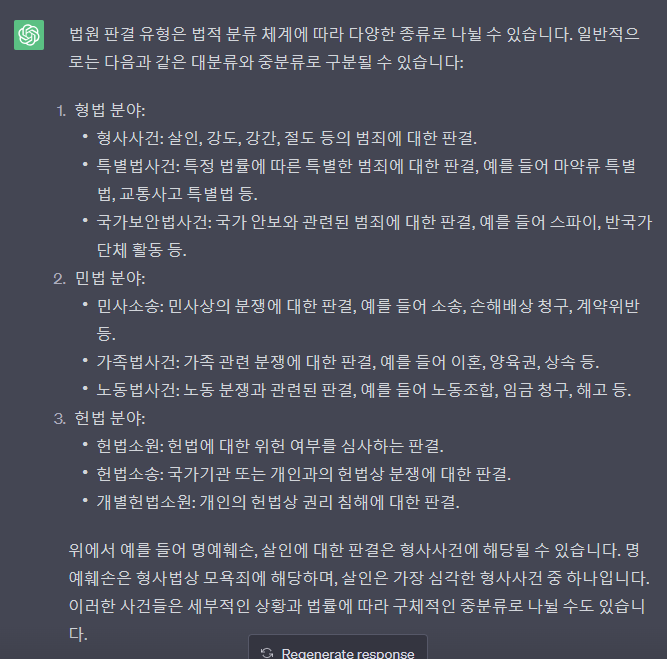

In [ ]:
## 형사
criminal = ['murder', 'robbery', 'rape', 'theft','larceny', 'criminal','assault',
'drug', 'traffic', 'spy', 'espionage', 'marijuana', 'rape', 'burglarious']

## 민사
civil = ['lawsuits', 'contract violations',
'divorce', 'child custody', 'inheritance',
'labor unions' , 'wage claims', 'terminations',
'defamation','Slander', 'libel', 'reputation','bankruptcy', 'fraud','kidnap'
]

## 헌법
constitutional = ['Constitutional Petitions',
'constitutional disputes',
'individual constitutional rights']

df = pd.DataFrame({
    'main_words':criminal + civil + constitutional,
    'category' : len(criminal)*["criminal"]+len(civil)*["civil"]+len(constitutional)*["constitutional"]
})

df['main_procssing']= df['main_words'].apply(cleaning)
df

,main_words,category,main_procssing
0,murder,criminal,murder
1,robbery,criminal,robberi
2,rape,criminal,rape
3,theft,criminal,theft
4,larceny,criminal,larceni
5,criminal,criminal,crimin
6,assault,criminal,assault
7,drug,criminal,drug
8,traffic,criminal,traffic
9,spy,criminal,spi


#### train : 최종 category 변수 생성

In [ ]:
def finding_cateory(lst):
    k = 0
    for item in lst:
      if item in df.main_procssing.values:
        k = df.loc[df['main_procssing'] == item, 'category'].values[0]
      # 값이 저장되었다면 for 구문 중단
      if k != 0:
        break
    # k 값이 없다면 기타
    if k == 0:
      k = 'others'
    return k

In [ ]:
train['category'] = 0

for i in range(len(train)):
  train['category'][i] = finding_cateory(keywords_list[i])

In [ ]:
train = train[['ID', 'first_party', 'second_party', 'facts','category', 'sen_len', 'word_len', 'first_party_winner'  ]]
train = train.rename(columns={'category':'issued_area'})
train

,ID,first_party,second_party,facts,issued_area,sen_len,word_len,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",others,7,201,1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,criminal,7,219,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,criminal,8,191,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,others,3,59,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",others,9,200,1
...,...,...,...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,others,5,144,1
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",others,7,184,1
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",criminal,6,195,0
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",others,8,194,0


#### test

In [ ]:
test['category'] = 0

for i in range(len(test)):
  test['category'][i] = finding_cateory(keywords_list[i])

In [ ]:
test = test[['ID', 'first_party', 'second_party', 'facts','category', 'sen_len', 'word_len']]
test = test.rename(columns={'category':'issued_area'})
test

,ID,first_party,second_party,facts,issued_area,sen_len,word_len
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,others,2,55
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,criminal,7,209
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...",criminal,7,181
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,others,6,99
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",others,6,154
...,...,...,...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",According to Executive Order No. 12807 signed ...,criminal,5,156
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.",Section 109(a) of the Clean Air Act (CAA) requ...,criminal,7,221
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,Linda Matteo and John Madigan created a plan f...,others,12,236
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,"In 1972, the North Carolina Board of Agricultu...",others,3,84


### winning_percent
**first_party_win_percent**
  첫 번째 당사자가 승소할 확률.
- 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
- test에서는 first_party가 train의 first_party와 겹치는 경우에는 해당 사람의 승소할 확률을 반영함. 겹치지 않는 경우는 0.5로 반영함.

##### train

In [ ]:
# winner: 해당 사건에서 승소한 사람
# win_percentage: 승소한 사람이 다른 사건에서도 승소할 확률

train['winner']=0
for i in range(2478):
  if train['first_party_winner'][i]==1:
    train['winner'][i] = train['first_party'][i]
  else:
    train['winner'][i] = train['second_party'][i]

train['win_percentage']=0
for i in range(2478):
  winner_exp = len(train.loc[train['first_party'] == train['winner'][i]])
  loose_exp = len(train.loc[train['second_party'] == train['winner'][i]])
  train['win_percentage'][i]= len(train.loc[train['winner'] == train['winner'][i]]) /(winner_exp + loose_exp)

In [ ]:
# first_party_frequency: first_party가 나타난 빈도
# first_party_win_percent: first_party가 승소할 확률
train['first_party_win_percent'] = 0
train['first_party_frequency'] = 0

for i in range(2478):
  train['first_party_frequency'][i] = len(train.loc[train['first_party'] == train['first_party'][i]]) + len(train.loc[train['second_party'] == train['first_party'][i]])

  # 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
  if train['first_party_frequency'][i] > 1:
    p = len(train.loc[train['winner'] == train['first_party'][i]]) / train['first_party_frequency'][i]
    train['first_party_win_percent'][i] = p
  else:
    train['first_party_win_percent'][i] = 0.5

##### test

In [ ]:
# train 기준 컬럼 생성
train_first_party = train[['first_party','first_party_win_percent']]
train_first_party = train_first_party.drop_duplicates()
train_first_party.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2470    False
2473    False
2474    False
2475    False
2477    False
Length: 2110, dtype: bool

In [ ]:
# 병합
test_percent = pd.merge(test.first_party, train_first_party, how='left')
test_percent = test_percent.fillna(0.5)

# test에 새로운 컬럼 추가
test['first_party_win_percent'] = test_percent['first_party_win_percent']

##### category

In [ ]:
def categorize_probability(x):
    if x == 0:
        return 0
    elif 0 < x <= 0.33:
        return 1
    elif 0.33 < x < 0.5:
        return 2
    elif x == 0.5:
        return 3
    elif 0.5 < x < 0.57:
        return 2
    elif 0.57 <= x < 0.75:
        return 4
    elif 0.75 <= x < 1:
        return 5
    elif x == 1:
        return 6
    else:
        return -1

In [ ]:
def categorize_probability2(x):
    if 0 <= x < 0.5:
        return 1
    elif x == 0.5:
        return 2
    elif 0.5 < x <= 1:
        return 3

In [ ]:
# 함수적용
train['winning_percent'] = train['first_party_win_percent'].apply(categorize_probability2)
test['winning_percent'] = test['first_party_win_percent'].apply(categorize_probability2)

### party 분류
Defining Entity type for each party
- https://github.com/smitp415/CSCI_544_Final_Project

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def data_distribution_graph(df, cols):
    for feature in cols:
        fig, ax = plt.subplots()
        percent = df.groupby(feature).size() / df[feature].count() * 100
        count = df.groupby(feature).size()

        if feature == 'facts_len':
          count = pd.cut(df['facts_len'], [1,50,500,1000,1500,3000,7000], include_lowest=True)
          percent = df.groupby(count).size() / df[feature].count() * 100
          count = df.groupby(count).size()
          ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,5), fontsize=12)
        elif feature == 'term':
          ax = percent.plot(kind='barh', figsize=(10,20), xticks = range(0,101,5), fontsize=12)
        else:
          ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,5), fontsize=12)

        # print count and percentage on grapp
        for i, v in enumerate(zip(percent.values, count.values)):
            percent = '{v}%'.format(v = round(v[0],2))
            ax.text(v[0] + 2, i - .25, percent, color='black', fontweight='bold', fontsize=12)
            ax.text(v[0] + 15, i - .25, str(v[1]), color='blue', fontweight='bold', fontsize=12)

        ax.set_title('Data Distribution - {feature}'.format(feature= feature), fontsize=20)
        ax.set_xlabel("Percentage", fontsize=20)
        ax.set_ylabel(feature, fontsize=20)

#### train

In [ ]:
for idx, value in train.iterrows():
  first = value['first_party']
  second = value['second_party']
  doc = nlp(first)
  for ent in doc.ents:
    train.loc[idx, 'first_party_ner'] = ent.label_
  doc = nlp(second)
  for ent in doc.ents:
    train.loc[idx, 'second_party_ner'] = ent.label_

#### test

In [ ]:
for idx, value in test.iterrows():
  first = value['first_party']
  second = value['second_party']
  doc = nlp(first)
  for ent in doc.ents:
    test.loc[idx, 'first_party_ner'] = ent.label_
  doc = nlp(second)
  for ent in doc.ents:
    test.loc[idx, 'second_party_ner'] = ent.label_

#### 카테고리 통합

person / org / gpe / others ( 나머지 카테고리 포함 + 결측값 )

In [ ]:
train.first_party_ner.value_counts(), train.second_party_ner.value_counts(),test.first_party_ner.value_counts(), test.second_party_ner.value_counts()

(PERSON         851
 ORG            759
 GPE            498
 NORP            11
 CARDINAL         9
 LOC              4
 PRODUCT          3
 LAW              2
 MONEY            2
 WORK_OF_ART      2
 LANGUAGE         1
 DATE             1
 FAC              1
 Name: first_party_ner, dtype: int64,
 PERSON         790
 ORG            695
 GPE            658
 NORP            18
 LOC              7
 CARDINAL         6
 WORK_OF_ART      4
 FAC              2
 PRODUCT          2
 DATE             1
 LAW              1
 Name: second_party_ner, dtype: int64,
 PERSON      417
 ORG         366
 GPE         279
 NORP         10
 LAW           3
 CARDINAL      2
 LOC           2
 DATE          1
 Name: first_party_ner, dtype: int64,
 PERSON      417
 ORG         366
 GPE         279
 NORP         10
 LAW           3
 LOC           2
 CARDINAL      2
 DATE          1
 Name: second_party_ner, dtype: int64)

In [ ]:
train.isnull().sum()

ID                           0
first_party                  0
second_party                 0
facts                        0
issued_area                  0
sen_len                      0
word_len                     0
first_party_winner           0
winner                       0
win_percentage               0
first_party_win_percent      0
first_party_frequency        0
winning_percent              0
first_party_ner            334
second_party_ner           294
dtype: int64

통합 !

In [ ]:
my_list = ['NORP', 'CARDINAL', 'LOC', 'PRODUCT', 'LAW', 'MONEY',
           'WORK_OF_ART', 'LANGUAGE', 'DATE', 'FAC']

# 다른 카테고리 모두 others로 통합
## train
train.loc[train['first_party_ner'].isin(my_list), 'first_party_ner'] = 'others'
train.loc[train['second_party_ner'].isin(my_list), 'second_party_ner'] = 'others'

## test
test.loc[test['first_party_ner'].isin(my_list), 'first_party_ner'] = 'others'
test.loc[test['second_party_ner'].isin(my_list), 'second_party_ner'] = 'others'

In [ ]:
# 결측값을 'others'로 치환
train.fillna('others', inplace=True)
test.fillna('others', inplace=True)

In [ ]:
train.isnull().sum()

ID                         0
first_party                0
second_party               0
facts                      0
issued_area                0
sen_len                    0
word_len                   0
first_party_winner         0
winner                     0
win_percentage             0
first_party_win_percent    0
first_party_frequency      0
winning_percent            0
first_party_ner            0
second_party_ner           0
dtype: int64

In [ ]:
train.first_party_ner.value_counts(), train.second_party_ner.value_counts(),test.first_party_ner.value_counts(), test.second_party_ner.value_counts()

(PERSON    851
 ORG       759
 GPE       498
 others    370
 Name: first_party_ner, dtype: int64,
 PERSON    790
 ORG       695
 GPE       658
 others    335
 Name: second_party_ner, dtype: int64,
 PERSON    417
 ORG       366
 GPE       279
 others    178
 Name: first_party_ner, dtype: int64,
 PERSON    417
 ORG       366
 GPE       279
 others    178
 Name: second_party_ner, dtype: int64)

### party name 치환

In [ ]:
# 이름 치환함수
def replace_name(name, text, replace_word):
    names = name.split('|')
    words = text.split()
    for word in words:
      for n in names:
        if n in word:
            text = text.replace(word, replace_word)

    return text

# 정규표현식으로 first_party 여러번 중복 연달아 나오는 거 한 번만 나오게 바꾸기
def remove_duplicates(text):
    modified_text1 = re.sub(r'(<p1>\s*)+', '<p1> ', text)
    modified_text2 = re.sub(r'(<p2>\s*)+', '<p2> ', modified_text1)

    return modified_text2

#### train

In [ ]:
# 데이터 손실 방지를 위해 값 복사
train['first_party1'] = train['first_party'].str.strip()
train['second_party1'] = train['second_party'].str.strip()
train['facts1'] = train['facts']

# 이름 치환을 위한 base
train['first_party1'] = train['first_party1'].str.replace(" ", "|")
train['second_party1'] = train['second_party1'].str.replace(" ", "|")

In [ ]:
# 함수 각각 적용
for i in range(len(train)):
  train['facts1'][i] = replace_name(train['first_party1'][i], train['facts1'][i], '<p1>')
  train['facts1'][i] = replace_name(train['second_party1'][i], train['facts1'][i], '<p2>')
  train['facts1'][i] = remove_duplicates(train['facts1'][i])

#### test

In [ ]:
# 데이터 손실 방지를 위해 값 복사
test['first_party1'] = test['first_party'].str.strip()
test['second_party1'] = test['second_party'].str.strip()
test['facts1'] = test['facts']

# 이름 치환을 위한 base
test['first_party1'] = test['first_party1'].str.replace(" ", "|")
test['second_party1'] = test['second_party1'].str.replace(" ", "|")

In [ ]:
# 함수 각각 적용
for i in range(len(test)):
  test['facts1'][i] = replace_name(test['first_party1'][i], test['facts1'][i], '<p1>')
  test['facts1'][i] = replace_name(test['second_party1'][i], test['facts1'][i], '<p2>')
  test['facts1'][i] = remove_duplicates(test['facts1'][i])

In [ ]:
test

,ID,first_party,second_party,facts,issued_area,sen_len,word_len,first_party_win_percent,winning_percent,second_party_ner,first_party_ner,first_party1,second_party1,facts1
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,others,2,55,0.5,2,GPE,others,Salerno,United|States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,criminal,7,209,0.5,2,ORG,PERSON,Milberg|Weiss|Bershad|Hynes|and|Lerach,"Lexecon,|Inc.",Lexecon <p2> was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...",criminal,7,181,0.5,2,ORG,ORG,No.|07-582\t|Title:|\t|Federal|Communications|...,"Fox|Television|Stations,|Inc.,|et|al.","In 2002 and 2003, <p2> Stations broadcast the ..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,others,6,99,0.5,2,GPE,PERSON,Harold|Kaufman,United|States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",others,6,154,0.5,2,others,PERSON,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",According to Executive Order No. 12807 signed ...,criminal,5,156,0.5,2,ORG,ORG,"Haitian|Centers|Council,|Inc.,|et|al.","Chris|Sale,|Acting|Commissioner,|Immigration|A...",According to Executive Order No. 12807 signed ...
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.",Section 109(a) of the Clean Air Act (CAA) requ...,criminal,7,221,0.5,2,ORG,others,Whitman,"American|Trucking|Associations,|Inc.",Section 109(a) of the Clean Air Act (CAA) requ...
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,Linda Matteo and John Madigan created a plan f...,others,12,236,0.5,2,PERSON,PERSON,Linda|A.|Matteo|and|John|J.|Madigan,William|G.|Barr,<p1> created a plan for utilizing $2.6 million...
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,"In 1972, the North Carolina Board of Agricultu...",others,3,84,0.5,2,PERSON,ORG,Washington|State|Apple|Advertising|Commission,Hunt,"In 1972, the North Carolina Board of Agricultu..."


# Data Preprocessing

## df 확인

In [ ]:
train_df = train[['ID',
                  'first_party_ner', 'second_party_ner',
                  'facts1',
                  'issued_area',
                 'sen_len', 'word_len',
                  'winning_percent',
                  'first_party_winner']]
test_df = test[['ID',
                  'first_party_ner', 'second_party_ner',
                  'facts1',
                  'issued_area',
                 'sen_len', 'word_len',
                  'winning_percent']]

train_df = train_df.rename(columns={"first_party_ner":"first_party",
                                    "second_party_ner":"second_party",
                                    'facts1':"fact",
                                    "first_party_win_percent":"winning_percent"
                                    })
test_df = test_df.rename(columns={"first_party_ner":"first_party",
                                    "second_party_ner":"second_party",
                                    'facts1':"fact",
                                    "first_party_win_percent":"winning_percent"
                                    })

# feature1, feature2를 범주형 변수로 변경
train_df['first_party'] = train_df['first_party'].astype('category')
train_df['second_party'] = train_df['second_party'].astype('category')
train_df['issued_area'] = train_df['issued_area'].astype('category')
train_df['winning_percent'] = train_df['winning_percent'].astype('category')

test_df['first_party'] = test_df['first_party'].astype('category')
test_df['second_party'] = test_df['second_party'].astype('category')
test_df['issued_area'] = test_df['issued_area'].astype('category')

## one_hot

In [ ]:
# 특정 범주형 변수(categorical variable)을 더미변수 생성
train_cat = pd.get_dummies(data = train_df[["first_party","second_party","issued_area"]], drop_first=True)
test_cat = pd.get_dummies(data = test_df[["first_party","second_party","issued_area"]], drop_first=True)

#train_cat = train_df[list(train_df.select_dtypes(include='category').columns)]
#test_cat = test_df[list(train_df.select_dtypes(include='category').columns)]

## fact_cleaning

In [ ]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
ps = nltk.stem.porter.PorterStemmer()
all_names=set(names.words())
lem = nltk.stem.wordnet.WordNetLemmatizer()

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    words = replaceAll.split()
    only_english = ''
    for word in words:
      if word in ['<p1>','<p2>']:
        only_english = only_english + word + ' '
      else:
        only_english += re.sub(r"[^a-zA-Z]", ' ', word)
        only_english += ' '  # 띄어쓰기 추가
    only_english = only_english.strip()

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 이름, 불용어(분석에 필요없는 토큰) 제거
    all_names=set(names.words())
    no_stops = [word for word in no_capitals if not word in all_names|stops]

    # 표제어 : 단어의 원형 형태를 나타내며, 명사의 경우 복수형이나 동사의 경우 시제 등을 고려하여 변환
    lem_text = [lem.lemmatize(word, pos='v') for word in no_stops]

    # 어근 추츨 : 단어의 형태를 보존하는 특징이 있지만 추출된 어근이 실제로는 사전에 존재하지 않은 단어일 수 있음
    stemmer_words = [ps.stem(word) for word in lem_text]

    # back to string from list
    text = " ".join(stemmer_words)

    return text

In [ ]:
# max_features: 기본값은 None이며, 추출할 최대 특징 수를 지정
vectorizer = TfidfVectorizer(max_features=400)

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['fact_processing'])
    else:
        X_facts = vectorizer.transform(df['fact_processing'])

    X = np.concatenate([X_facts.todense()], axis=1)
    return X

In [ ]:
# 데이터 클리닝
train_df["fact_processing"] = train_df["fact"].apply(cleaning)
#train_fact = train_df["fact_processing"]

test_df["fact_processing"] = test_df["fact"].apply(cleaning)
#test_fact = test_df["fact_processing"]

In [ ]:
train_df[['fact_processing']]

,fact_processing
0,june <p1> candid public offic make televis spe...
1,ramon nelson rid bike suffer lethal blow back ...
2,alabama state court convict <p1> murder senten...
3,victor <p1> convict state court evid illeg obt...
4,april selma <p2> intrud break apart daughter c...
...,...
2473,congress amend clean air act energi polici act...
2474,<p2> invest fund purchas approxim million unse...
2475,district court sentenc manuel <p1> month impri...
2476,march enrico <p2> law perman resid plead guilt...


In [ ]:
# 데이터 벡터화
train_fact = get_vector(vectorizer, train_df, True)
train_fact = np.asarray(train_fact)
train_fact = pd.DataFrame(data=train_fact, columns=vectorizer.get_feature_names_out())

test_fact = get_vector(vectorizer, test_df, True)
test_fact = np.asarray(test_fact)
test_fact = pd.DataFrame(data=test_fact, columns=vectorizer.get_feature_names_out())

## 수치형

In [ ]:
train_num = train_df[['sen_len', 'word_len']]
train_target = train_df[['first_party_winner']]

test_num = train_df[['sen_len', 'word_len']]

## df 통합

In [ ]:
train_fin = pd.concat([train_fact,train_cat,train_num,train_target],axis=1,join='inner')
test_fin = pd.concat([test_fact, test_cat, test_num],axis=1,join='inner')

# Define Model & Train

In [ ]:
from sklearn.model_selection import train_test_split
X = train_fin.drop(columns={'first_party_winner'})
y = train_fin['first_party_winner']

# X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            #        test_size=0.2,
                                             #       random_state=0)

## CatBoost Classifier
- 범주형 변수를 One-hot Encoding, Label Encoding 등 encoding 작업을 하지 않고도 그대로 모델의 input으로 사용
- 하지만 범주형 변수의 cardinality가 작은 경우에는 One-hot Encoding을 진행
  - Python의 CatBoostClassifier 혹은 CatBoostRegressor의 one_hot_max_size를 설정하면 범주형 변수의 범주 수가 지정된 값보다 작으면 One-hot Encoding을 진행



---
- iterations: 훈련 반복 횟수를 지정합니다.
- learning_rate: 학습률을 조정하여 모델 훈련 속도와 정확도를 조절합니다.
- depth: 트리의 깊이를 제어하여 모델의 복잡성을 조정합니다.
- l2_leaf_reg: L2 정규화 항에 대한 가중치를 지정합니다. 모델의 일반화 성능을 향상시키는 데 도움이 될 수 있습니다.
- border_count: 범주형 특성 분할에 사용되는 트리 노드의 최대 개수를 지정합니다.
- colsample_bylevel: 각 레벨에서 사용할 특성의 비율을 지정합니다.
- eval_metric: 모델의 평가 메트릭을 선택합니다.    
  분류 문제에서는 Accuracy, Logloss, AUC 등을 사용할 수 있습니다.
- random_seed: 재현성을 위해 사용되는 난수 시드 값을 설정합니다.


In [ ]:
# 각 클래스에 대해 다른 가중치를 부여
y = train['first_party_winner']
counts = list(y.value_counts())
class_weight = [counts[1]/sum(counts), counts[0]/sum(counts)]
print("weight :", class_weight)

weight : [0.33454398708635996, 0.66545601291364]


In [ ]:
# 범주형 변수 지정
# cat_features = list(train_df.select_dtypes(include='category').columns)

# 모델 정의
model = CatBoostClassifier(random_seed=42,
                           class_weights=class_weight,
                           verbose=0
                     #      cat_features=cat_features
                           )

# 모델 적합
model.fit(X, y)

In [ ]:
'''# ML Metrics
from sklearn.metrics import make_scorer, accuracy_score
# ML Model selection
from sklearn.model_selection import GridSearchCV

model_cat = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss'],
 #         'l2_leaf_reg': np.logspace(-20, -19, 3),
 #         'leaf_estimation_iterations': [10],
          'eval_metric': ['Accuracy'],
           'use_best_model': ['True'],
          'random_seed': [42]
         }
scorer = make_scorer(accuracy_score)
clf_grid = GridSearchCV(estimator=model_cat,
                        param_grid=params,
                        scoring=scorer,
                        cv=5
                        )
clf_grid.fit(X,y)
best_param = clf_grid.best_params_
best_param'''

In [ ]:
X_test = test_fin
X_test = np.asarray(X_test)
Y_pred = model.predict(X_test)

In [ ]:
# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

1    1219
0      21
dtype: int64

## XGBoost Classifier



---------
- max_depth (default=6): 트리의 최대 깊이를 제어
- learning_rate (default=0.1): 학습률로, 각 트리의 기여를 제어
- n_estimators (default=100): 생성할 트리의 개수
- subsample (default=1): 각 트리에 사용할 샘플의 비율을 제어
- colsample_bytree (default=1): 각 트리에 사용할 특성의 비율을 제어
- reg_alpha (default=0): L1 정규화 항의 가중치
- reg_lambda (default=1): L2 정규화 항의 가중치입
- gamma (default=0): 트리 노드의 분할을 위한 최소 손실 감소량

In [ ]:
# 각 클래스에 대해 다른 가중치를 부여
y = train['first_party_winner']
counts = list(y.value_counts())
class_weight = [counts[1]/sum(counts), counts[0]/sum(counts)]
print("weight :", class_weight)

weight : [0.33454398708635996, 0.66545601291364]


In [ ]:
# 모델 정의
from xgboost import XGBClassifier
model_xgb = XGBClassifier(n_jobs=-1,
                    scale_pos_weight=4.6,
                    max_depth=3,
                    random_state=2)
# 모델 적합
model_xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2, ...)

- estimator: 사용할 모델 객체를 지정합니다.
- param_grid: 탐색할 하이퍼파라미터 조합을 딕셔너리 형태로 지정합니다.
- scoring: 모델의 성능을 평가하는 방법을 지정합니다.
- cv: 교차 검증을 위한 폴드 수를 지정합니다.
- refit: 그리드 서치 종료 후, 최적의 하이퍼파라미터로 전체 데이터에 대해 모델을 학습할지 여부를 지정합니다.
- error_score: 모델이 학습 중 오류가 발생했을 때의 처리 방식을 지정합니다.
- n_jobs: 병렬로 그리드 서치를 수행할 때 사용할 CPU 코어 수를 지정합니다.
- verbose: 그리드 서치 수행 과정에서의 출력 레벨을 지정

### (1) 첫번째 시도

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', model_xgb)
])

param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, error_score='raise')
grid.fit(X, y)

NameError: ignored

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', model_xgb)
])

param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, error_score='raise')
grid.fit(X, y)

In [ ]:
#튜닝된 파라미터 출력
print(grid.best_params_)

In [ ]:
# 1차적으로 튜닝된 파라미터를 가지고 객체 생성
xgb_model = XGBClassifier(max_depth = 2,
                         n_estimators = 100,
                         n_components = 10)

# 학습
xgb_model.fit(X,y)

[00:30:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_components" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_components=10, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# train 기준 accuracy 확인
y_pred = xgb_model.predict(X)
accuracy = accuracy_score(y, y_pred)
accuracy

NameError: ignored

In [ ]:
# test 확인
X_test = np.asarray(test_fin)
Y_pred = xgb_model.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

1    947
0    293
dtype: int64

In [ ]:
submit['first_party_winner'] = Y_pred
submit.to_csv('./submit_xgboost.csv', index=False)
print('Done')

Done


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ftr_importances_values = xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
ftr_importances = ftr_importances.sort_values(ascending=False)  # 정렬

top_k = 50  # 확인하려는 상위 레코드 개수

plt.figure(figsize=(8,6))
plt.title('Top {} Feature Importances'.format(top_k))
sns.barplot(x=ftr_importances[:top_k], y=ftr_importances.index[:top_k])
plt.show()

In [ ]:
lst = [str(idx) for idx in list(ftr_importances.index[:50])]
train_xx = train_fin.copy()
train_xx.columns = train_xx.columns.astype(str)

train_xx[lst]

### (2) *두번째 시도*

In [ ]:
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('pca', PCA(n_components = 10)),
    ('model', XGBClassifier(max_depth = 2,
                         n_estimators = 100))
])

pipeline.fit(X,y)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('pca', PCA(n_components=10)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
# train 기준 accuracy 확인
y_pred = pipeline.predict(X)
accuracy = accuracy_score(y, y_pred)
accuracy

NameError: ignored

In [ ]:
# test 확인
X_test = np.asarray(test_fin)
Y_pred = pipeline.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

1    1180
0      60
dtype: int64

## LGBM



---------
- boosting_type (기본값='gbdt'): 부스팅 유형을 지정합니다. 'gbdt'는 일반적인 그래디언트 부스팅을 의미하며, 'dart', 'goss' 등 다른 옵션도 사용할 수 있습니다.
- num_leaves (기본값=31): 트리에 존재할 수 있는 최대 잎의 수입니다. 높은 값은 모델의 복잡도를 증가시킬 수 있지만, 과적합의 위험도 증가할 수 있습니다.
- max_depth (기본값=-1): 트리의 최대 깊이를 제한합니다. 음수 값인 경우 제한이 없습니다.
- learning_rate (기본값=0.1): 학습 속도를 조절하는 값으로, 각 트리의 영향력을 조절합니다.
- n_estimators (기본값=100): 생성할 트리의 개수입니다.
- subsample (기본값=1.0): 각 트리의 학습에 사용될 샘플의 비율을 지정합니다. 과적합 방지를 위해 값이 1.0보다 작게 설정할 수 있습니다.
- colsample_bytree (기본값=1.0): 각 트리의 학습에 사용될 특성의 비율을 지정합니다.
-reg_alpha (기본값=0.0): L1 정규화(규제)의 강도를 조절합니다.
- reg_lambda (기본값=0.0): L2 정규화(규제)의 강도를 조절합니다.
- min_child_samples (기본값=20): 리프 노드가 되기 위한 최소한의 데이터 샘플 개수를 지정합니다. 과적합 방지를 위해 사용됩니다.

In [ ]:
# 특정 범주형 변수(categorical variable)을 더미변수 생성
#train_cat = pd.get_dummies(data = train_df[["first_party","second_party","issued_area"]], drop_first=True)
#test_cat = pd.get_dummies(data = test_df[["first_party","second_party","issued_area"]], drop_first=True)

train_cat = train_df[list(train_df.select_dtypes(include='category').columns)]
test_cat = test_df[list(train_df.select_dtypes(include='category').columns)]

train_fin = pd.concat([train_fact,train_cat,train_num,train_target],axis=1,join='inner')
test_fin = pd.concat([test_fact, test_cat, test_num],axis=1,join='inner')

In [ ]:
from sklearn.model_selection import train_test_split
X = train_fin.drop(columns={'first_party_winner'})
y = train_fin['first_party_winner']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

In [ ]:
# prediction, label -> f1 score
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score

def get_f1_score(preds, labels):
  preds = np.argmax(preds, axis = 1)

  score = f1_score(preds, labels, average='macro')

  return score

In [ ]:
import lightgbm as model_lgb

def lightgbm_train(x_train: pd.DataFrame,
                   y_train: pd.DataFrame,
                   x_valid: pd.DataFrame,
                   y_valid: pd.DataFrame,
                   categorical_features: list,
                   params):

      lgb_train = model_lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
      lgb_valid = model_lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)

      model = model_lgb.train(
                params = params,
                train_set = lgb_train,
                valid_sets = lgb_valid,
                num_boost_round = 10000,
      )

      ## prediction
      valid_pred = model.predict(x_valid)
      train_pred = model.predict(x_train)

      train_f1 = get_f1_score(train_pred, y_train)
      valid_f1 = get_f1_score(valid_pred, y_valid)

      print(f"lightgbm: train_f1 = {train_f1}")
      print(f"lightgbm: valid_f1 = {valid_f1}")

      return model

In [ ]:
# 범주형 변수 지정
cat_features = list(train_df.select_dtypes(include='category').columns)

# 베이스 파라미터
lgb_params_base = {
      'objective': 'multiclass',
      'metric': 'multi_logloss',
      'num_class': 3,
      'device_type':'cpu',
      'feature_fraction': 0.50,
      'bagging_fraction': 0.80,
      'n_jobs': -1,
      'is_unbalance':True,
      'seed': 42,
      'early_stopping':200,
      'learning_rate': 0.005,
      'num_leaves': 5,
      'lambda_l1':3,
      'lambda_l2': 4,
      'verbose':1000
    }


# base 모델
lgb_model_base = lightgbm_train(X_train, y_train,
                                X_test, y_test,
                                cat_features,
                                lgb_params_base)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.918759
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.896564
[LightGBM] [Debug] init for col-wise cost 0.008905 seconds, init for row-wise cost 0.009845 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24263
[LightGBM] [Info] Number of data points in the train set: 1982, number of used features: 406
[LightGBM] [Info] Start training from score -1.121062
[LightGBM] [Info] Start training from score -0.394426
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[1]	valid_0's multi_logloss: 0.662415
Training until validation scores don't improve for 200 rounds
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth

In [ ]:
test_fin

,abort,access,act,action,activ,actual,administr,admit,affirm,agenc,...,would,writ,year,york,first_party,second_party,issued_area,winning_percent,sen_len,word_len
0,0.0,0.0,0.158984,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,others,GPE,others,2,7,201
1,0.0,0.0,0.000000,0.282648,0.0,0.0,0.000000,0.000000,0.048168,0.000000,...,0.0,0.0,0.0,0.000000,PERSON,ORG,criminal,2,7,219
2,0.0,0.0,0.068059,0.000000,0.0,0.0,0.124201,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,ORG,ORG,criminal,2,8,191
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.182098,0.170553,0.000000,...,0.0,0.0,0.0,0.000000,PERSON,GPE,others,2,3,59
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,PERSON,others,others,2,9,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,0.0,0.0,0.073933,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.163162,ORG,ORG,criminal,2,5,157
1236,0.0,0.0,0.062422,0.000000,0.0,0.0,0.341743,0.000000,0.000000,0.242915,...,0.0,0.0,0.0,0.000000,others,ORG,criminal,2,6,218
1237,0.0,0.0,0.000000,0.076272,0.0,0.0,0.000000,0.000000,0.051992,0.000000,...,0.0,0.0,0.0,0.000000,PERSON,PERSON,others,2,4,148
1238,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,ORG,PERSON,others,2,7,185


In [ ]:
X_test = np.asarray(test_fin)
Y_pred = lgb_model_base.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

ValueError: ignored

In [ ]:
submit['first_party_winner'] = Y_pred
submit.to_csv('./submit_xgboost0703.csv', index=False)
print('Done')

Done


## Boosting 앙상블

In [ ]:
# 특정 범주형 변수(categorical variable)을 더미변수 생성
train_cat = pd.get_dummies(data = train_df[["first_party","second_party","issued_area"]], drop_first=True)
test_cat = pd.get_dummies(data = test_df[["first_party","second_party","issued_area"]], drop_first=True)

#train_cat = train_df[list(train_df.select_dtypes(include='category').columns)]
#test_cat = test_df[list(train_df.select_dtypes(include='category').columns)]

train_fin = pd.concat([train_fact,train_cat,train_num,train_target],axis=1,join='inner')
test_fin = pd.concat([test_fact, test_cat, test_num],axis=1,join='inner')

X_train = train_fin.drop(columns={'first_party_winner'})
y_train = train_fin['first_party_winner'].astype('category')

X_test = np.asarray(test_fin)

In [ ]:
X_train

,act,action,activ,actual,addit,administr,admit,affirm,agenc,agent,...,first_party_ORG,first_party_PERSON,first_party_others,second_party_ORG,second_party_PERSON,second_party_others,issued_area_criminal,issued_area_others,sen_len,word_len
0,0.071479,0.000000,0.141011,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,1,0,0,1,0,0,1,7,201
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,1,0,0,1,0,1,0,7,219
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,1,0,0,0,0,1,0,8,191
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0,0,1,0,0,1,0,1,3,59
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.175023,0.078894,0.000000,0.0,...,0,1,0,0,0,0,0,1,9,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,0.138034,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.145406,0.0,...,1,0,0,1,0,0,0,1,5,144
2474,0.000000,0.090972,0.000000,0.0,0.000000,0.0,0.000000,0.061473,0.000000,0.0,...,0,1,0,1,0,0,0,1,7,184
2475,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.053455,0.000000,0.0,...,1,0,0,0,0,0,1,0,6,195
2476,0.178368,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.057859,0.000000,0.0,...,1,0,0,0,0,1,0,1,8,194


In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model1 = LGBMClassifier(n_estimators=400)
model1.fit(X=X_train, y=y_train)

model2 = XGBClassifier()
model2.fit(X=X_train, y=y_train)

model3 =  RandomForestClassifier()
model3.fit(X=X_train, y=y_train)

RandomForestClassifier()

In [ ]:
Y_pred = model1.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

1    874
0    366
dtype: int64

In [ ]:
Y_pred = model2.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

1    884
0    356
dtype: int64

In [ ]:
submit['first_party_winner'] = Y_pred
submit.to_csv('./submit_model2.csv', index=False)
print('Done')

Done


In [ ]:
Y_pred = model3.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

1    1054
0     186
dtype: int64

# Inference & Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
X_test = np.asarray(test_fin)
Y_pred = model.predict(X_test)
pd.DataFrame(list(Y_pred)).value_counts()

In [ ]:
submit['first_party_winner'] = Y_pred
submit.to_csv('./submit_catboost0701_3.csv', index=False)
print('Done')

Done
